In [1]:
from pathlib import Path
ROOT = Path('/Users/ihor/Documents/Py/Yay/ml-services/doc2graph')

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def file_to_images(file, gray=False):
    import fitz

    if file[-3:].lower() == 'pdf':
        imgs = []
        
        zoom = 3    # zoom factor
        mat = fitz.Matrix(zoom, zoom)
        
        with fitz.open(file) as pdf:
            for pno in range(pdf.page_count):
                page = pdf.load_page(pno)
                pix = page.get_pixmap(matrix=mat)
                # if width or height > 2000 pixels, don't enlarge the image
                #if pix.width > 2000 or pix.height > 2000:
                #    pix = page.get_pixmap(matrix=fitz.Matrix(1, 1)
                
                mode = "RGBA" if pix.alpha else "RGB"                        
                img = Image.frombytes(mode, [pix.width, pix.height], pix.samples)                        
                
                if gray:
                    img = img.convert('L')
                else:
                    img = img.convert('RGB')
                    
                imgs.append(img)
    else:
        if gray:
            img = Image.open(file).convert('L')
        else:
            img = Image.open(file).convert('RGB')
            
        imgs=[img]

    return imgs

In [5]:
from PIL import Image, ImageDraw, ImageFont

image_name = '3db20986-b966-486a-b4c7-7f88ffc92f10.jpg' #! change this to see different outputs from FUNSD, or pass your own image!
image_path = f'data/{image_name}'
image = Image.open(image_path).convert('RGB')


In [6]:
from doc2graph.src.data.preprocessing import center

def draw_results(img, boxs, links, labels):
    draw = ImageDraw.Draw(img)

    for box in boxs:
        draw.rectangle(box, outline='blue', width=3)
    
    if links:
        for idx in range(len(links['src'])):
            key_center = center(boxs[links['src'][idx]])
            value_center = center(boxs[links['dst'][idx]])
            draw.ellipse((tuple(x-4 for x in key_center) + tuple(x+4 for x in key_center)), fill = 'red')
            draw.ellipse((tuple(x-4 for x in value_center) + tuple(x+4 for x in value_center)), fill = 'red')
            draw.line((key_center, value_center), fill='red', width=3)
            

In [7]:
def get_word_boxes(image_path, host):
    def unnormalize_box(bbox, width, height):
        return [
            width * (bbox[0] / 1000),
            height * (bbox[1] / 1000),
            width * (bbox[2] / 1000),
            height * (bbox[3] / 1000),
        ]
        
    import io
    import requests
    import base64
    import json

    pil_image = file_to_images(image_path)[0]
    width, height = pil_image.size
    with io.BytesIO() as buffer:
        pil_image.save(buffer, format='jpeg')
        image_bytes = buffer.getvalue()
        
    data = {
        "image_bytes":base64.b64encode(image_bytes).decode("utf8")
    }

    response = requests.post(f"{host}",
                    data=json.dumps(data),
                    headers={'content-type':'application/json',
                            'x-amzn-RequestId': '84cad557-a68f-45db-9c01-79449f0aeecb'},#image/jpg
                    timeout=29
                    )
    
    ict_str = response.content.decode("UTF-8")
    res = json.loads(ict_str)
    
    res['boxes'] = [unnormalize_box(bbox, width, height) for bbox in res['boxes']]
    
    return res

In [8]:
source_file= 'data/1686161984132_05af746e-0414-4255-af87-862678d5f17c_DHSPart17.pdf'
target_file= 'data/1685484224508_0455103c-074a-42c5-bc05-aa534505d658_RecordtransferACH052623.pdf'

In [10]:
source_word_boxes = get_word_boxes(source_file, 'https://xiqo6syt8a.execute-api.us-east-1.amazonaws.com/paddleocr_textboxes/calc_embedding')
target_word_boxes = get_word_boxes(target_file, 'https://xiqo6syt8a.execute-api.us-east-1.amazonaws.com/paddleocr_textboxes/calc_embedding')

In [11]:
from doc2graph.src.data.graph_builder import box_distance
import numpy as np
from sklearn.metrics import pairwise_distances

In [15]:
from doc2graph.src.data.graph_builder import GraphBuilder, get_lines, merge_boxes

gb = GraphBuilder(data_type = 'word_boxes',
                  edge_type = 'fully',
                  node_granularity = 'gt',
                  word_to_word='word_to_word')

graphs, _, _, features = gb.get_graph(
    [source_file,target_file], 
    'CUSTOM',
    [source_word_boxes, target_word_boxes])

In [37]:
idx=0
graph = graphs[idx]
boxes = features['boxs'][idx]
text = features['texts'][idx]

u,v = graph.edges()
links = {'src': u, 'dst': v}

lines = get_lines(boxes, u, v)

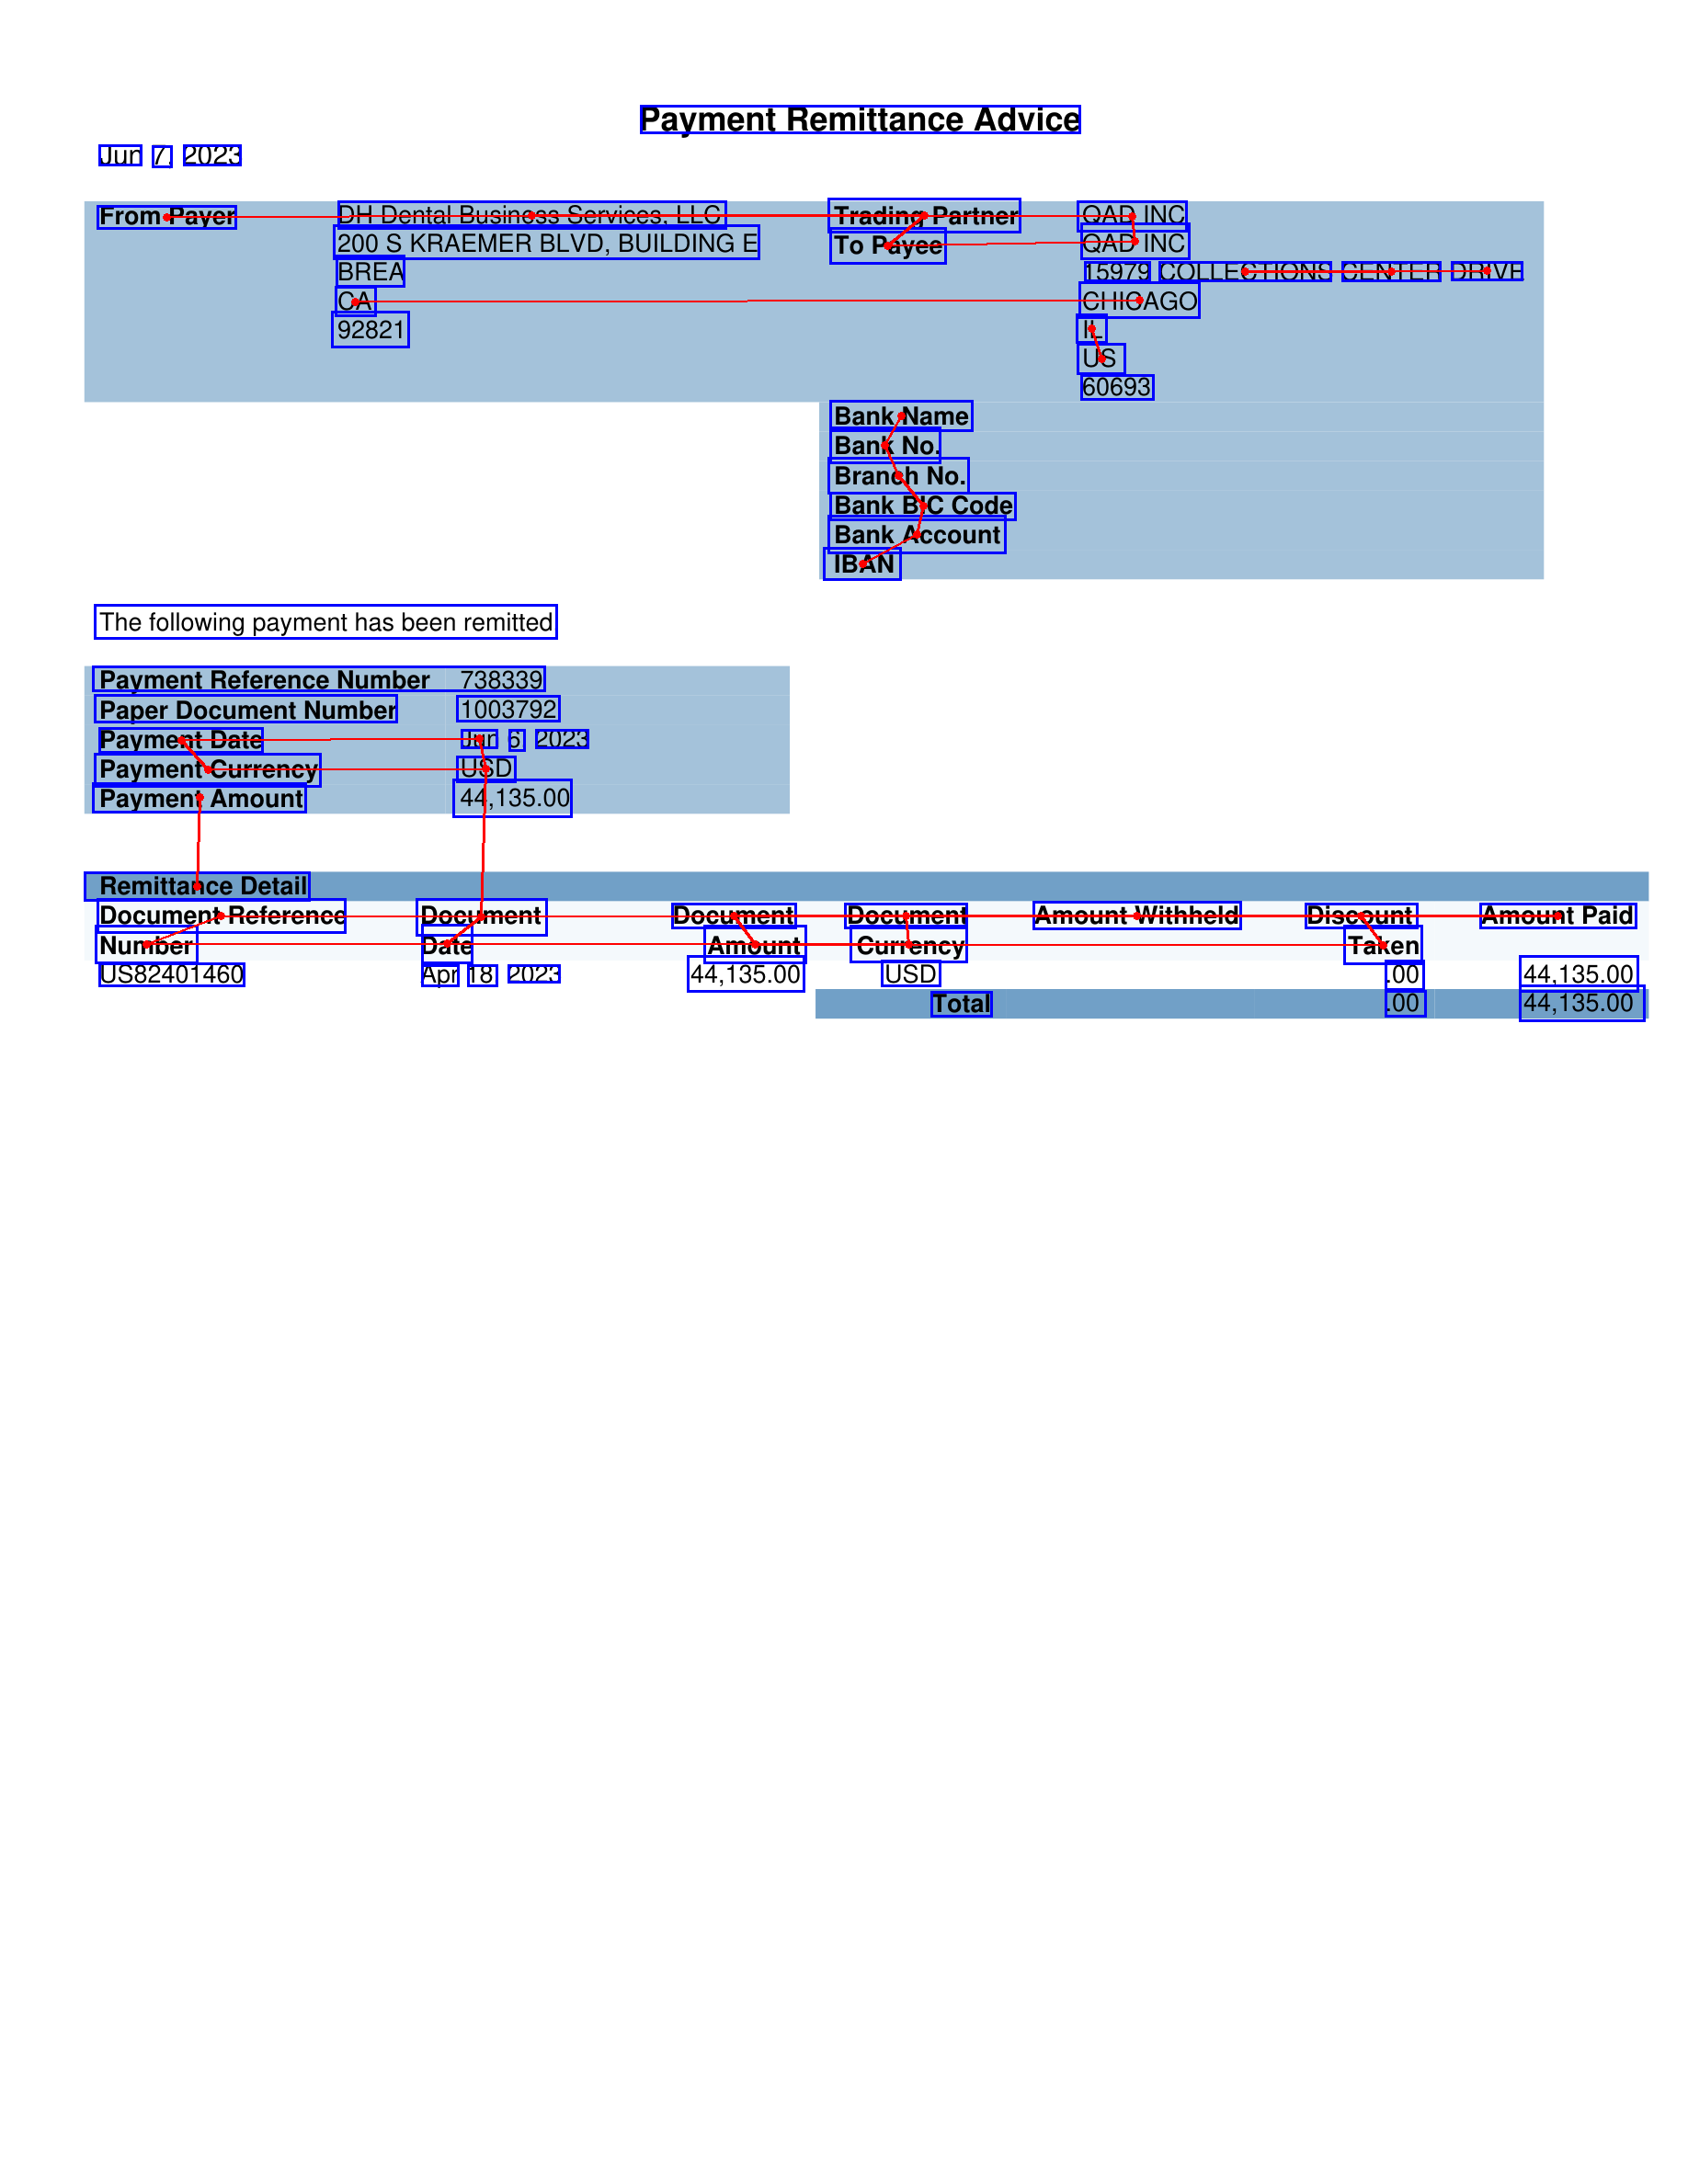

In [39]:
image_path = features['paths'][idx]
image = file_to_images(image_path)[0]
im_c = image.copy()

draw_results(im_c, boxes, links, None)
# merged_boxes=[]
# for line in lines:
#     line_boxes = [boxes[x] for x in line]
#     merged_boxes.append(merge_boxes(line_boxes))

# draw_results(im_c, merged_boxes, None, None)

im_c

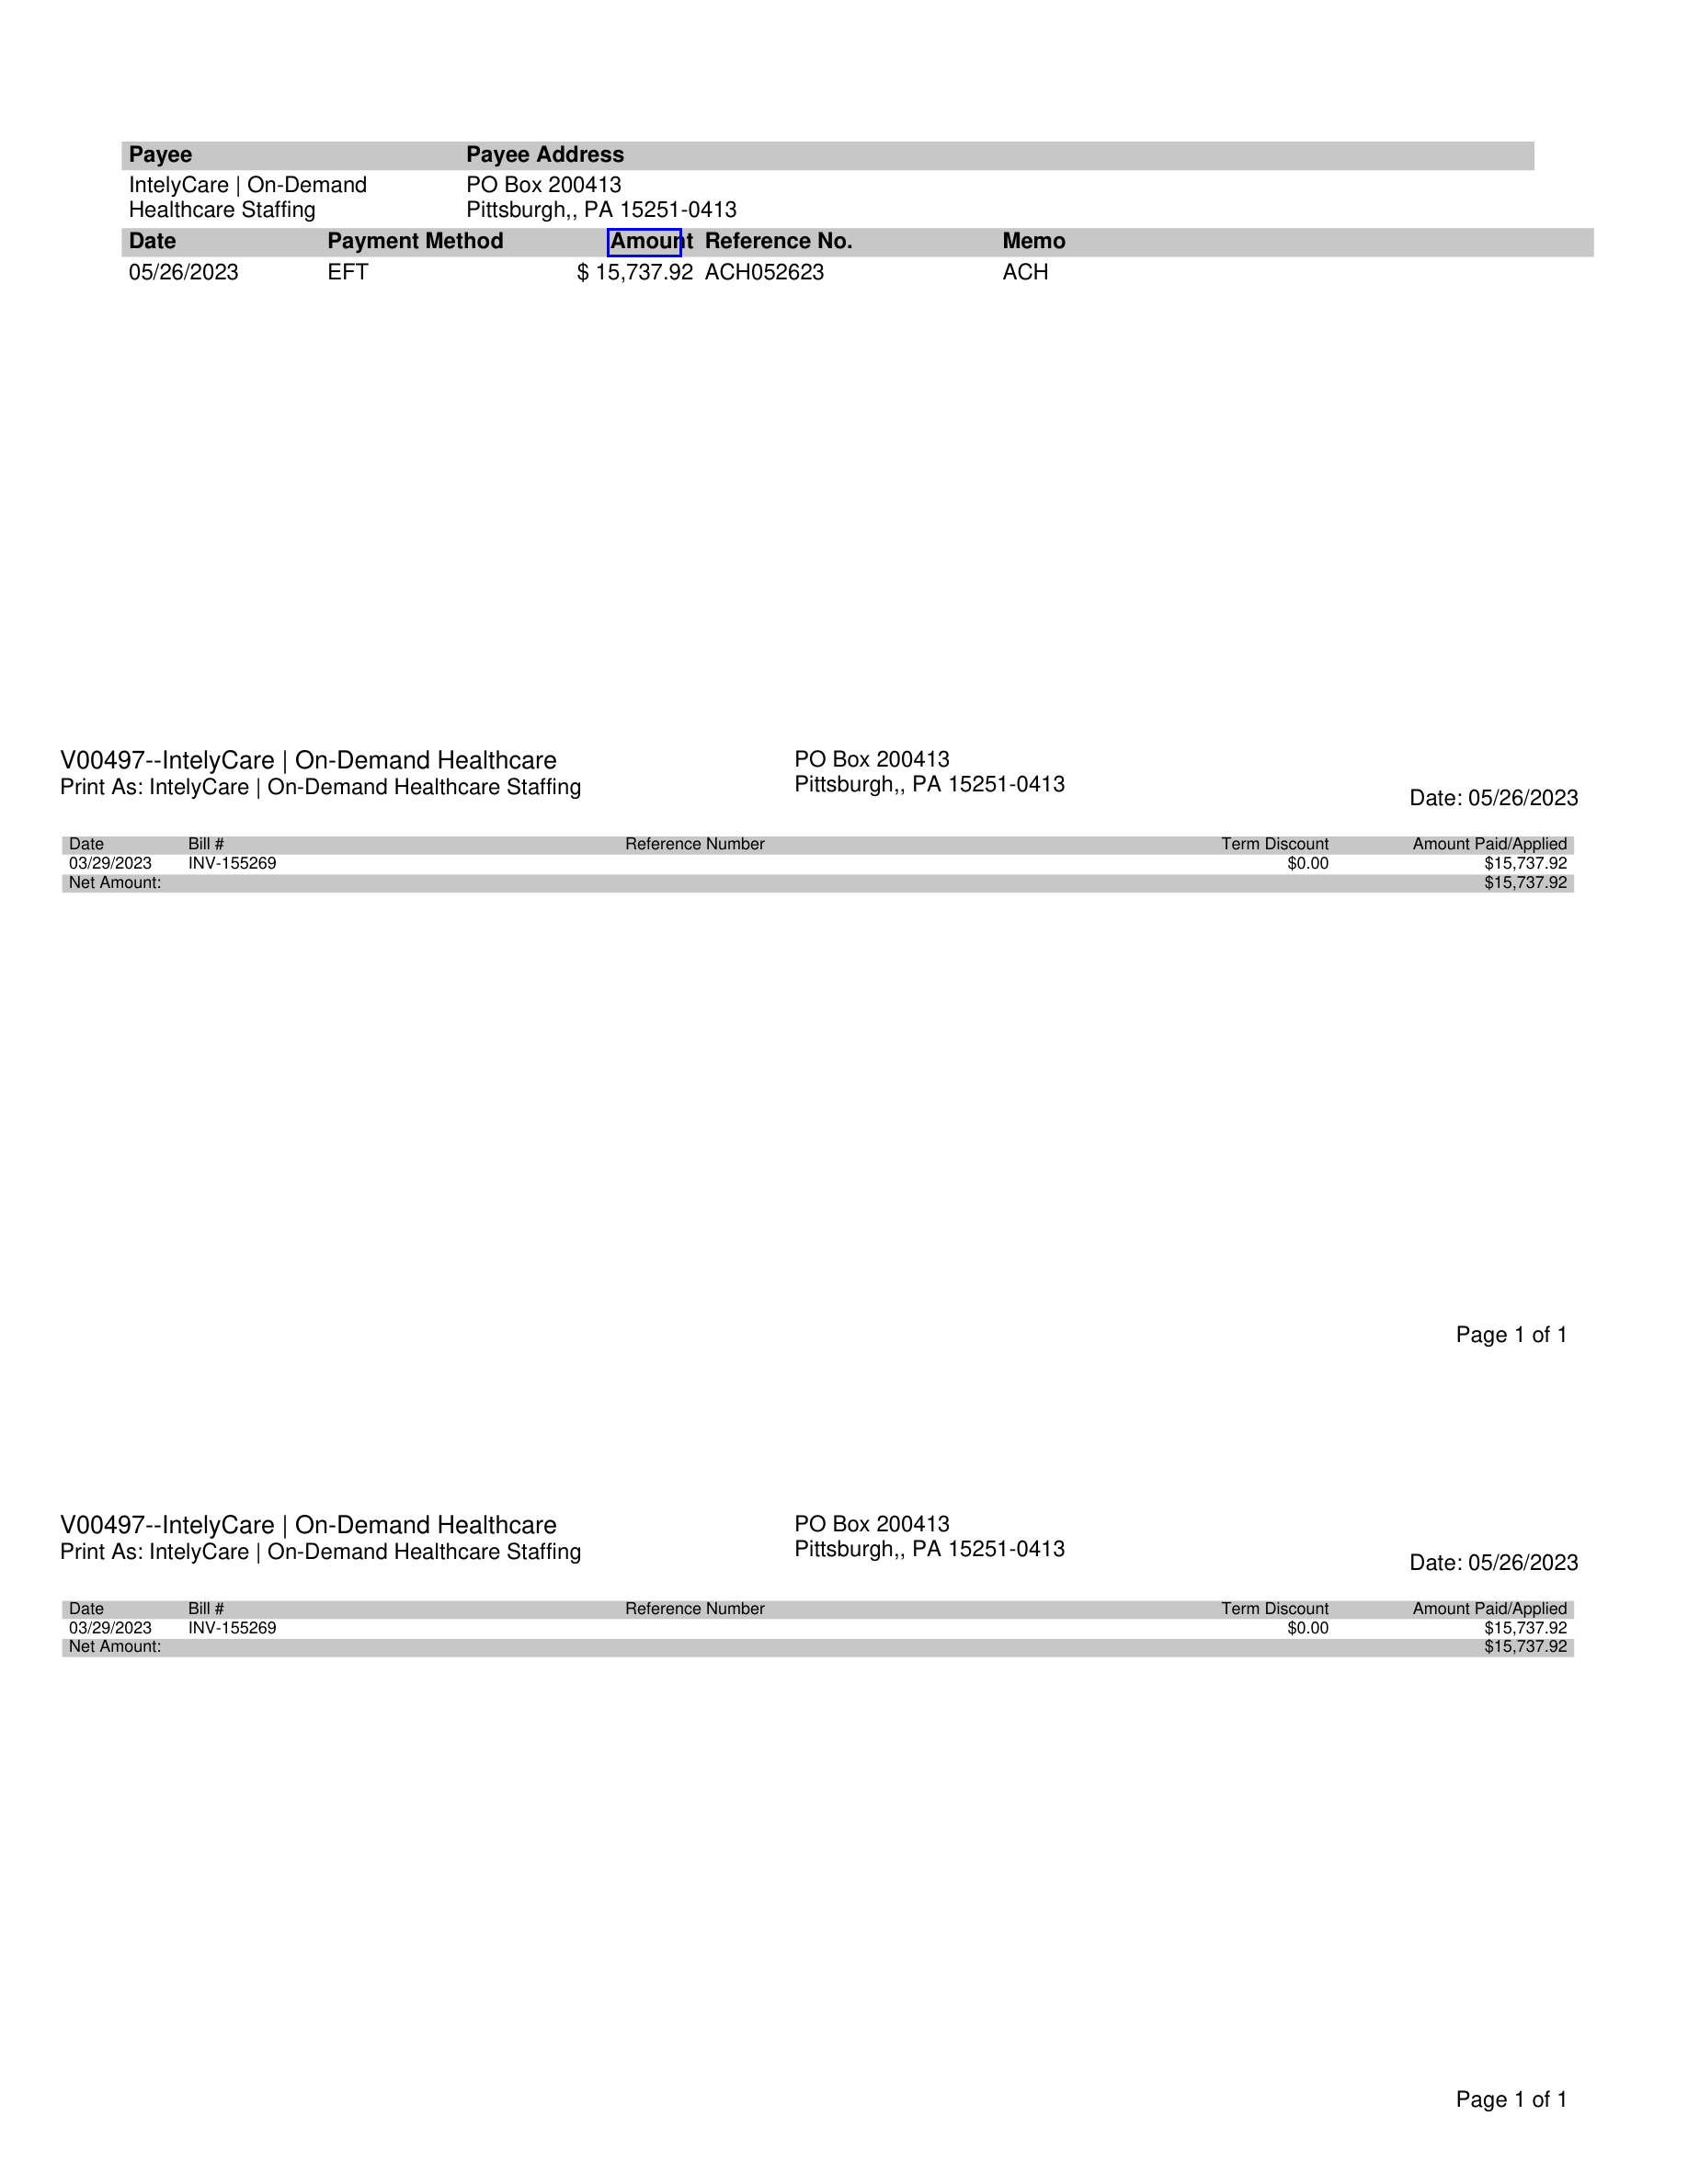

In [36]:
image_path = features['paths'][idx]
image = file_to_images(image_path)[0]
im_c = image.copy()

draw_results(im_c, [boxes[10]], None, None)
# merged_boxes=[]
# for line in lines:
#     line_boxes = [boxes[x] for x in line]
#     merged_boxes.append(merge_boxes(line_boxes))

# draw_results(im_c, merged_boxes, None, None)

im_c

In [ ]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
for i in range(2,15):
    clustering = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage='single').fit(pairwise_distance) #AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage='single')
    print(i,silhouette_score(pairwise_distance,clustering.labels_, metric = 'precomputed'))

In [145]:
clustering =  AgglomerativeClustering(n_clusters=8, affinity='precomputed', linkage='single').fit(pd)

In [19]:
from doc2graph.src.data.feature_builder import FeatureBuilder

device = 'cpu'#'cuda:0'
fb = FeatureBuilder(add_mask=True)
fb.get_info()

-> textual feats: True
-> text masked: True
-> visual feats: False
-> geom feats: False
-> size feats: False
-> edge epolar: False
-> edge edist: False


In [20]:
chunks, _ = fb.add_features(graphs, features) # chunks is used by the model to merge different embeddings together!
graphs, chunks

adding features: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


([Graph(num_nodes=64, num_edges=72,
        ndata_schemes={'geom': Scheme(shape=(4,), dtype=torch.float32), 'feat': Scheme(shape=(384,), dtype=torch.float32), 'norm': Scheme(shape=(1,), dtype=torch.float32)}
        edata_schemes={'feat': Scheme(shape=(0,), dtype=torch.float32), 'weights': Scheme(shape=(), dtype=torch.float32)}),
  Graph(num_nodes=66, num_edges=40,
        ndata_schemes={'geom': Scheme(shape=(4,), dtype=torch.float32), 'feat': Scheme(shape=(384,), dtype=torch.float32), 'norm': Scheme(shape=(1,), dtype=torch.float32)}
        edata_schemes={'feat': Scheme(shape=(0,), dtype=torch.float32), 'weights': Scheme(shape=(), dtype=torch.float32)})],
 [384])

In [21]:
from doc2graph.src.models.utils import GATv2ConvM
from torch_geometric.nn import GATv2Conv

conv = GATv2ConvM(sum(chunks), sum(chunks), edge_dim = 2, heads=1, dropout = 0, v2 = True, add_self_loops = False, aggr='add', bias=False)
conv2 = GATv2ConvM(2*sum(chunks), 2*sum(chunks), edge_dim = 2, heads=1, dropout = 0, v2 = True, add_self_loops = False, aggr='add', bias=False)


In [23]:
import torch
from torch_geometric.data import Data

graph_features=[]
for graph in graphs:
    geometric_graph = Data(x=graph.ndata['feat'], 
                        edge_index= torch.stack(graph.edges(), dim=0).to(torch.int64), 
                        edge_attr= graph.edata['feat'])
    x, edge_index, edge_attr = geometric_graph.x, geometric_graph.edge_index, geometric_graph.edge_attr
    
    x_new = conv(x, edge_index)
    #x_new = conv2(x_new, edge_index)
    
    graph_features.append(x_new)

In [27]:
x.size(), x_new.size()

(torch.Size([66, 384]), torch.Size([66, 768]))

In [32]:
features.keys()

dict_keys(['paths', 'texts', 'boxs'])

In [24]:
from sklearn.metrics import pairwise_distances
import numpy as np
from torchmetrics.functional.pairwise import pairwise_cosine_similarity, pairwise_euclidean_distance

pairwise_dist = pairwise_euclidean_distance(graph_features[0], graph_features[1]).detach().numpy()
pairwise_dist[np.isnan(pairwise_dist)] = 0

def features_dist(a,b):
    n = len(a)//2
    res1 = np.linalg.norm(a[:n]-b[:n])
    res2 = np.linalg.norm(a[n:]-b[n:])
    return res1*0.8+res2*0.2

pairwise_dist = pairwise_distances(graph_features[0], graph_features[1] ,metric = features_dist)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchmetrics/functional/pairwise/euclidean.py:33: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)
  y_norm = y.norm(dim=1).T


In [26]:
pairwise_dist.shape

(64, 66)

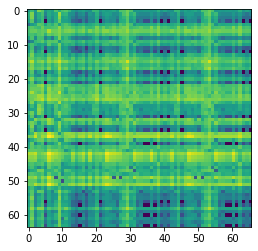

In [25]:
import matplotlib.pyplot as plt
plt.imshow(pairwise_dist, interpolation='none')

In [28]:
import numpy as np
for idx in [0]:
    geom = features['boxs'][idx]
    text = features['texts'][idx]
    print(len(geom))
    for i in range(len(geom)):
        if  text[i] in ['Check/Ref No','Date','Payment','Reference','Amount', 'Check Date','Payment Number','Totals','Check Number']:
            print(i,text[i])
            #print(list(graph_features[idx][i].detach().numpy()))
            #print(list(x_new[i].detach().numpy()))
            
            d = pairwise_dist[i]
            target_id = np.argmin(d)
            print(min(d),target_id, features['texts'][1][target_id])
            #break
    #break

64
49 Date
2.2103136062622073 27 Date
50 Amount
2.0988689422607423 10 Amount


# Model

In [143]:
import torch
from doc2graph.src.models.graphs import SetModel
from doc2graph.src.paths import CHECKPOINTS

device = 'cpu'
sm = SetModel(name='gat', device=device)
model = sm.get_model(7, 4, [300], False) # 4 and 2 refers to nodes and edge classes, check paper for details!
#model.load_state_dict(torch.load(CHECKPOINTS / 'gat-20230807-1428.pt', map_location=torch.device('cpu'))) # load pretrained model
model.eval()


### MODEL ###
-> Using GAT
-> Total params: 286291
-> Device: False



GAT(
  (drop): Dropout(p=0, inplace=False)
  (message_passing): GATv2ConvM(300, 300, heads=1)
  (node_pred): InputProjectorSimple(
    (node_pred): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=256, out_features=7, bias=True)
    )
  )
)

In [144]:
sm.cfg_model

AttrDict({'name': 'GAT', 'dropout': 0, 'n_heads': 1, 'node_projector_dim': 128, 'edge_projector_dim': 128, 'num_layers': 1, 'doProject': False, 'doNorm': False})

In [656]:

# from doc2graph.src.data.dataloader import Document2Graph
# from doc2graph.src.paths import TEST_SAMPLES, INF, REMITTANCE_TEST

# test_data = Document2Graph(name='REMITTANCE TEST', src_path=INF, device = device, output_dir=TEST_SAMPLES)
# test_data.get_info()

In [14]:
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

In [265]:
from torch_geometric.data import Data
pygraph = Data()
dgl_graph = graphs[0]
        
geometric_graph = Data(x=dgl_graph.ndata['feat'], 
                        edge_index= torch.stack(dgl_graph.edges(), dim=0).to(torch.int64), 
                        edge_attr= dgl_graph.edata['feat'])

geometric_graph = geometric_graph.to(device)
geometric_graph['geom'] = dgl_graph.ndata['geom']

In [266]:
node_unique_labels =['O', 'invoice_amount', 'invoice_date', 'invoice_number', 'payment_amount', 'payment_date', 'payment_number']

In [270]:
from torch.nn import functional as F
import numpy as np
from doc2graph.src.training.utils import *

ind=1
#graph = test_data.graphs[ind]
#inference = Image.open(test_data.paths[ind]).convert('RGB')
graph = graphs[0]
inference = image.copy()
size = inference.size

boxes = list(graph.ndata['geom'].numpy())
boxes = [unnormalize_box(box, size[0], size[1]) for box in boxes]

with torch.no_grad():
    n = model(geometric_graph.to(device))
    score, npreds = torch.max(F.softmax(n, dim=1), dim=1)
    
    arr = npreds.numpy()
    li = list(np.where(arr>0)[0]) 
    
    labels = [node_unique_labels[arr[i]]+f'%6.2f' %score[i] for i in li]
    score = [f'%6.2f' % score[i] for i in li]

    # save results
    links = (epreds == 1).nonzero(as_tuple=True)[0].tolist()
    
    entities = [boxes[i] for i in li]

    inference = draw_boxes(inference, entities, labels)
    
inference

NameError: name 'model' is not defined

# Test

In [185]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 2],
                           [1, 1, 1]], dtype=torch.long)
x = torch.tensor([[1], [1], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

In [717]:
from doc2graph.src.main import seed_everything
from doc2graph.src.models.utils import GATConvM

import os
import random
import numpy as np
import torch
import pytorch_lightning as pl


seed = 42
#random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

edge_index = torch.tensor([[1, 2, 3,1,2], [0, 0, 0,1,2]], dtype=torch.long)  # 2 x E
edge_attr = torch.tensor([[1,2], [1,2], [1,2], [1,2],[1,2]], dtype=torch.float)
x = torch.tensor([[1,1], [2,2], [3,3], [4,4]], dtype=torch.float)  # N x emb(in)
x, edge_index

conv1 = GATConvM(2, 2, add_self_loops = False,  bias = False, edge_dim = 2)
conv1(x, edge_index, edge_attr)

tensor([[0.0657, 1.1494, 0.2504, 4.3802],
        [0.1314, 2.2987, 0.1314, 2.2987],
        [0.1971, 3.4481, 0.1971, 3.4481],
        [0.2628, 4.5974, 0.0000, 0.0000]], grad_fn=<ViewBackward0>)

In [750]:
from doc2graph.src.data.dataloader import Document2Graph
from doc2graph.src.paths import *

In [865]:
#test_data = Document2Graph(name='REMITTANCE TEST', src_path=REMITTANCE_TEST, device = device, output_dir=TEST_SAMPLES)
#test_data.get_info()
inf_data = Document2Graph(name='REMITTANCE INFERENCE', src_path=REMITTANCE_INFERENCE, device = device, output_dir=INFERENCE_SAMPLES)
inf_data.get_info()
test_data = inf_data

adding features: 100%|██████████| 10/10 [00:00<00:00, 65.59it/s]


REMITTANCE INFERENCE dataset:
-> graphs: 10
-> node labels: ['O' 'payment_amount']
-> edge labels: ['none']
-> node features: 6
-> edge type: fully
-> textual feats: False
                 -> visual feats: False
                 -> geom feats: False
                 -> size feats: False
                 -> edge epolar: False
                 -> edge edist: True
-> graph example: Graph(num_nodes=43, num_edges=18,
      ndata_schemes={'geom': Scheme(shape=(4,), dtype=torch.float32), 'feat': Scheme(shape=(6,), dtype=torch.float32), 'norm': Scheme(shape=(1,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32), 'weights': Scheme(shape=(), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)})


In [866]:
idx=1
data = test_data[idx]

In [922]:
x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

In [925]:
from doc2graph.src.models.utils import GCNConvM, SAGEConvM, InputProjectorSimple, GATConvM, GATv2ConvM
conv = GATv2ConvM(6, 6, edge_dim = 2, heads=1, dropout = 0, v2 = True, add_self_loops = False, aggr='add', bias=False)
x_new = conv(x, edge_index)

In [910]:
geom = data['geom']
text = data['text']
for i in range(geom.shape[0]):
    print(list(x_new[i].detach().numpy()), text[i], data.y[i].numpy() ) #list(geom[i].numpy()), list(data.x[i].numpy()),'->',

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] P.O 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Box 0
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0] 248 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Vendor 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] ACP 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Green 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Bay, 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] WI 0
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0] 54305 0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] (920) 435-5353 0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Fax (920) 438-0389 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Payment 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] cccp.com 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] CreativIT 0
[0.0, 0.0, 0.0

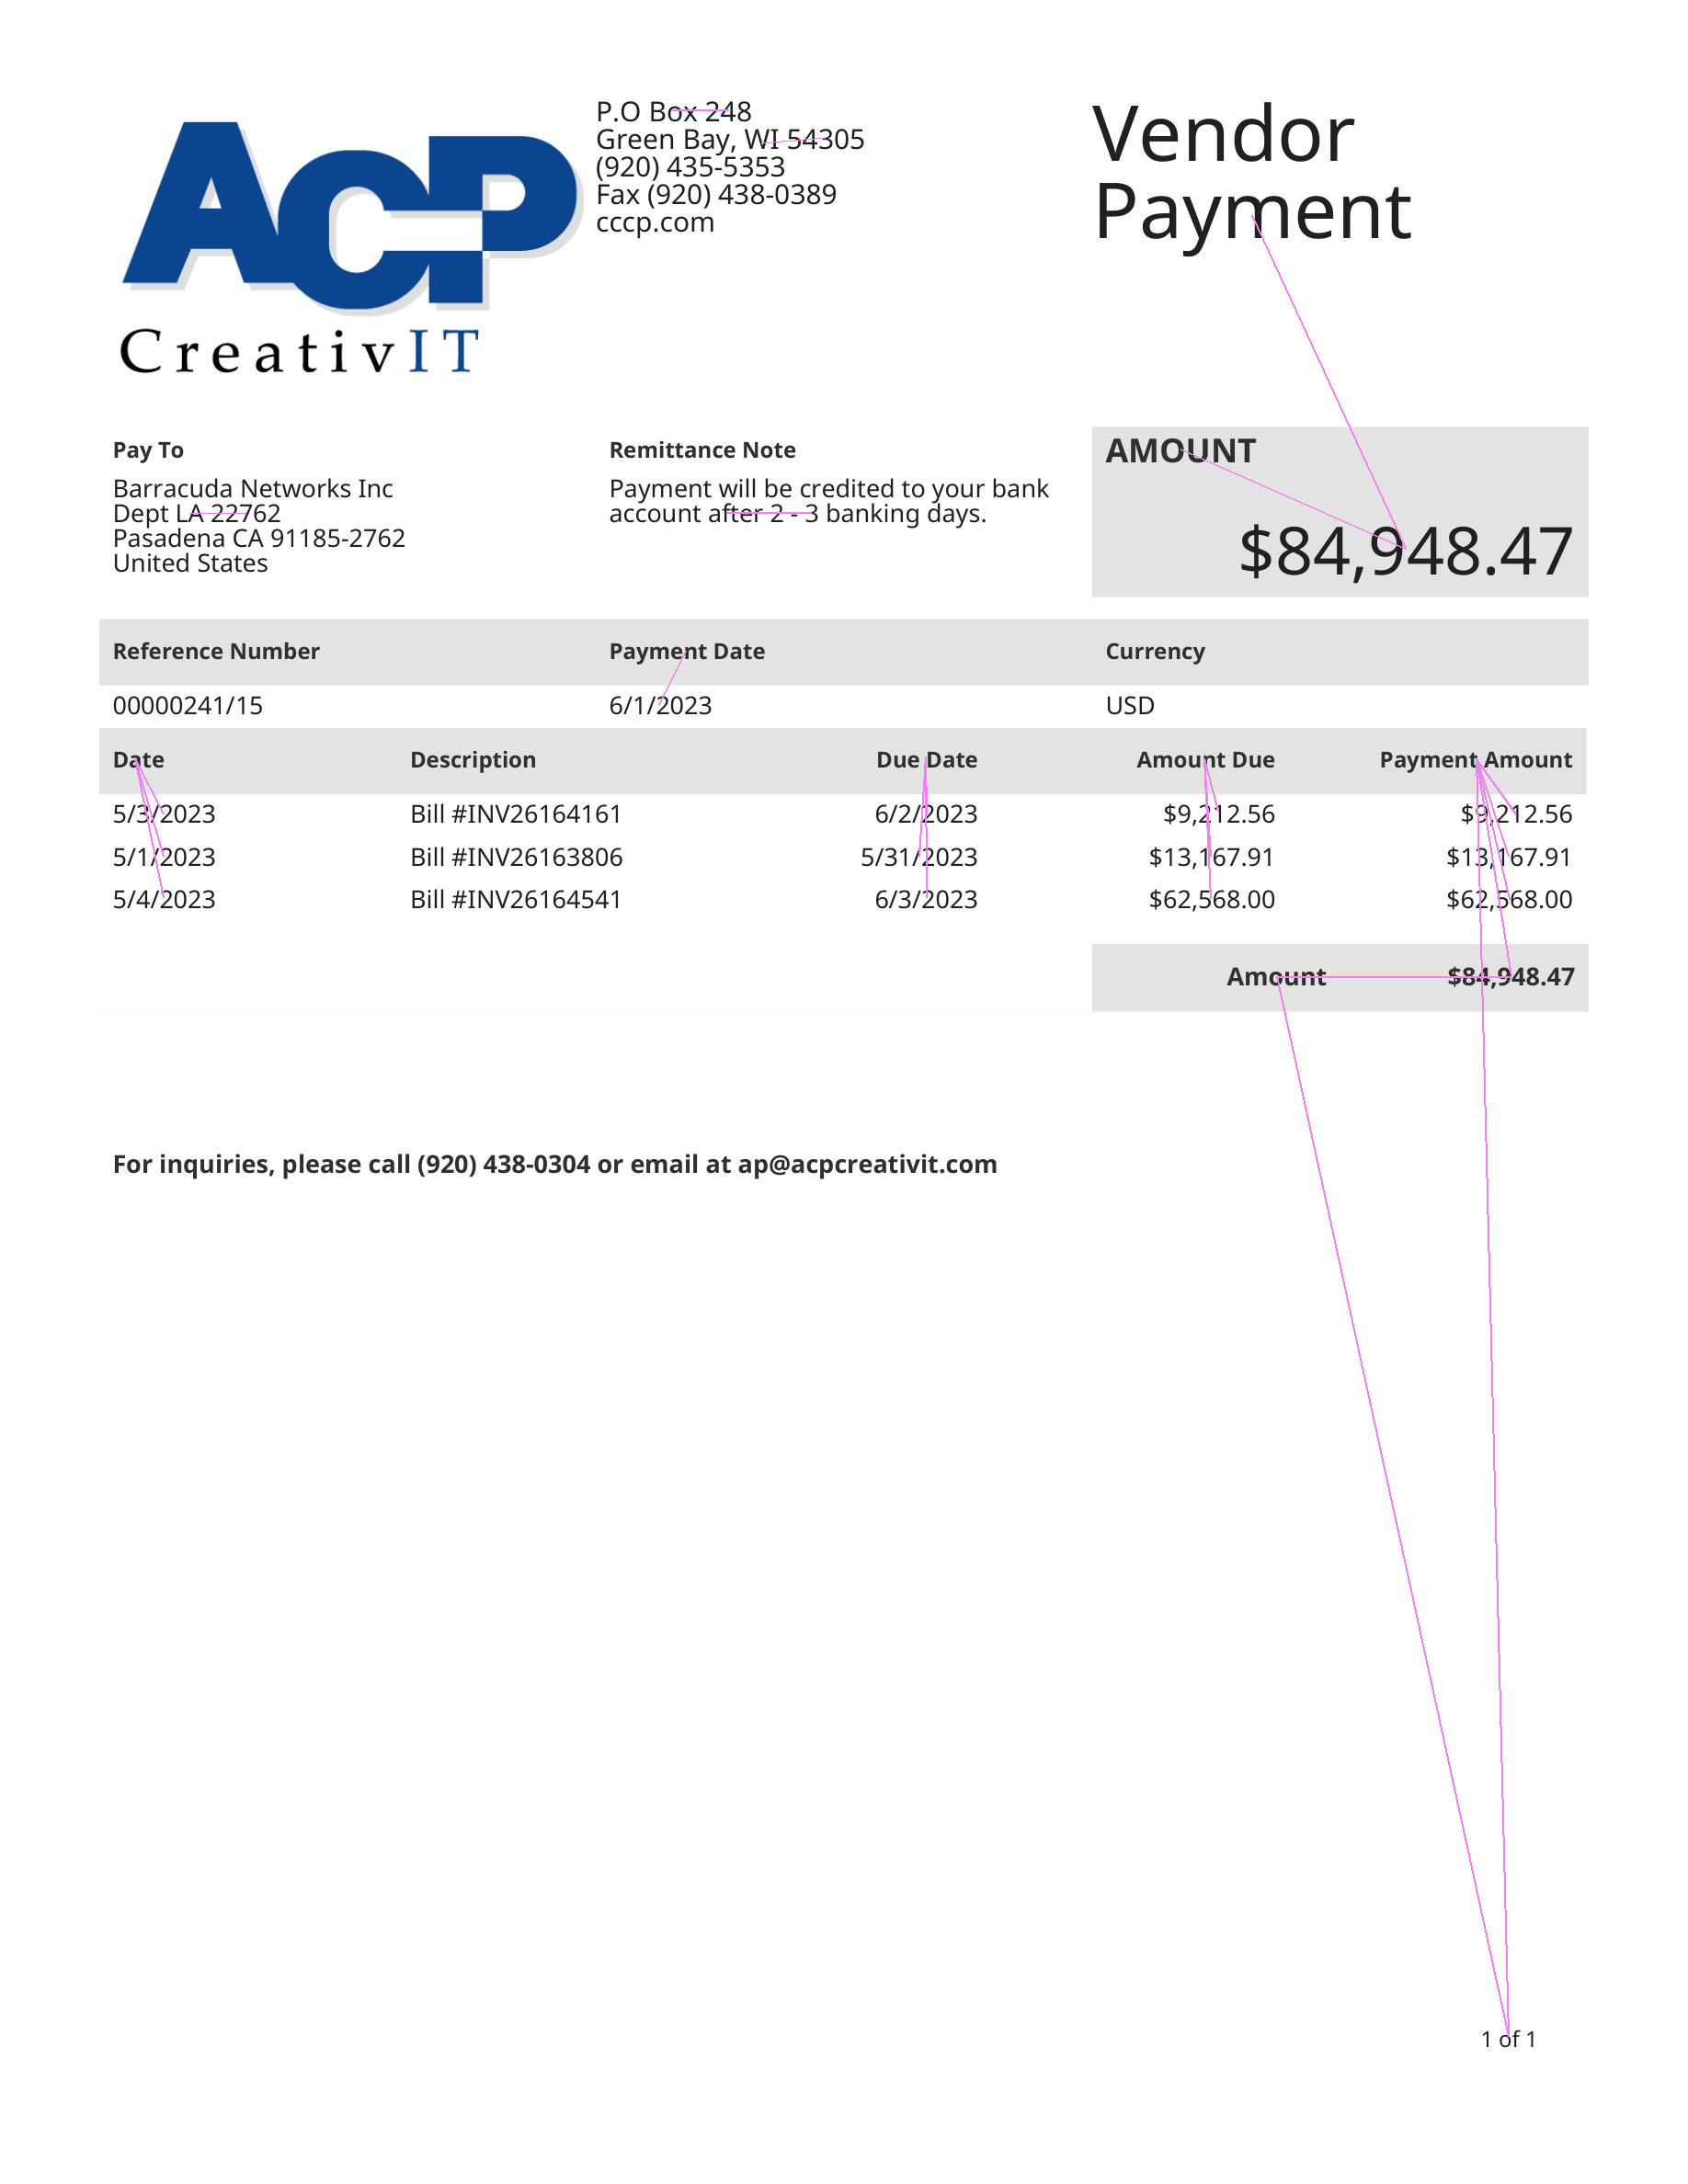

In [909]:
from doc2graph.src.data.preprocessing import unnormalize_box, draw_boxes


img_path = test_data.paths[idx]
img_name = os.path.basename(img_path)
        
inference = Image.open(img_path).convert('RGB')
size = inference.size

boxes = list(geom.numpy())
boxes = [unnormalize_box(box, size[0], size[1]) for box in boxes]
        
u, v = test_data.graphs[idx].edges()
links = {'src': u, 'dst': v}
        
inference = draw_boxes(inference, boxes, [], labels=None, links = links, scores=None)
inference

In [1005]:
import torch
from torch_geometric.nn import GATv2Conv

# Example input
x = torch.tensor([[0, 0, 1, 0], [0, 0, 1, 0],[0, 1, 0, 0]], dtype=torch.float)
edge_index = torch.tensor([[0, 1, 2], [1, 1, 2]], dtype=torch.int)  # Example edge indices

# Create a GATv2ConvM layer
n_heads = 1
dropout = 0
gat_layer = GATv2ConvM(4, 4, edge_dim=None, heads=n_heads, dropout=dropout, bias = False)#, aggr='add', add_self_loops=True)

# Forward pass through the GATv2ConvM layer
output = gat_layer(x, edge_index)

print("Output shape:", output.shape)


Output shape: torch.Size([3, 8])
